In [1]:
# 數據分析常用套件
import pandas as pd
import numpy as np

In [2]:
# 輸入資料
train0 = pd.read_csv("C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\train.csv")
test0 = pd.read_csv("C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\test.csv")

In [5]:
# 保存 PassengerId
test_ids = test0['PassengerId']

# 刪除不必要欄位
train0.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)
test0.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

In [7]:
# 檢查資料是否有遺失值與異常值
misstrain = train0.isnull().sum()
print(misstrain)

misstest = test0.isnull().sum()
print(misstest)

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64
HomePlanet       87
CryoSleep        93
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
dtype: int64


In [9]:
#補遺失值
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# 1. 數值欄位填補：使用 IterativeImputer
from sklearn.experimental import enable_iterative_imputer  # 啟用實驗性功能
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

train_num = train0[num_cols]
test_num = test0[num_cols]

# 合併數值資料以保持一致性
all_num = pd.concat([train_num, test_num], axis=0)

num_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=42),
    max_iter=100,
    tol=1e-2,
    initial_strategy='mean',
    random_state=42
)

imputed_all_num = num_imputer.fit_transform(all_num)
train0[num_cols] = imputed_all_num[:len(train_num), :]
test0[num_cols]  = imputed_all_num[len(train_num):, :]

# 2. 類別欄位初步填補 & Label Encoding (以 "missing" 為缺失的標記)
# 先將原本的缺失值填上 "missing"
for col in cat_cols:
    train0[col] = train0[col].fillna("missing")
    test0[col]  = test0[col].fillna("missing")

# 接著進行 Label Encoding
from sklearn.preprocessing import LabelEncoder
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    all_data = pd.concat([train0[col], test0[col]], axis=0).astype(str)
    le.fit(all_data)
    train0[col] = le.transform(train0[col].astype(str))
    test0[col]  = le.transform(test0[col].astype(str))
    encoders[col] = le

# 3. 隨機森林進行類別變數差補：對原本填上 "missing" 的部分重新預測
from sklearn.ensemble import RandomForestClassifier

def impute_cat_rf(df, target_col, features, random_state=42, n_estimators=100):
    # 取得 "missing" 對應的 label（在編碼時指定的特殊值）
    missing_label = encoders[target_col].transform(["missing"])[0]
    mask = (df[target_col] == missing_label)
    if mask.sum() == 0:
        return df
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    # 只用那些原本不是缺失（非 "missing"）的資料進行訓練
    clf.fit(df.loc[~mask, features], df.loc[~mask, target_col])
    # 用訓練好的模型預測缺失部分
    df.loc[mask, target_col] = clf.predict(df.loc[mask, features])
    return df

# 對每個類別欄位，利用數值欄位以及其他類別欄位作為特徵進行預測
# 這裡使用的特徵：數值欄位 + 其他類別欄位 (排除目標欄)
for col in cat_cols:
    features = num_cols + [c for c in cat_cols if c != col]
    train0 = impute_cat_rf(train0, col, features, random_state=42)
    test0  = impute_cat_rf(test0, col, features, random_state=42)

# 4. 檢查是否還有缺失值
print("Train0 missing值數量：")
print(train0.isnull().sum())
print("\nTest0 missing值數量：")
print(test0.isnull().sum())

C:\Users\jiayuchen\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Train0 missing值數量：
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

Test0 missing值數量：
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


        feature  importance
3           Age    0.152161
9        VRDeck    0.139046
5   RoomService    0.137874
8           Spa    0.137249
1     CryoSleep    0.123367
6     FoodCourt    0.117344
7  ShoppingMall    0.104986
0    HomePlanet    0.060796
2   Destination    0.024446
4           VIP    0.002731


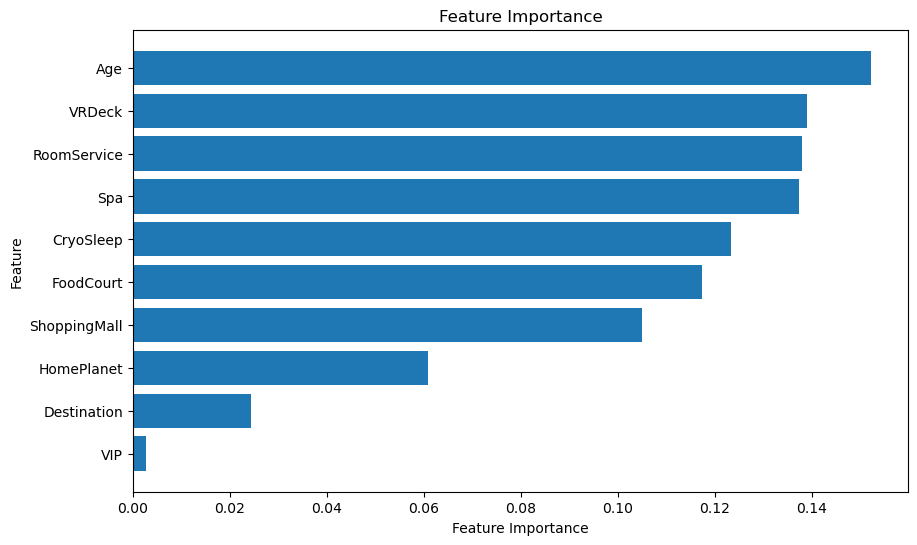

In [10]:
# 找出重要的特徵
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 假設 train0 中已經包含填補缺失值、編碼好的資料，且目標變數為 'Transported'
X = train0.drop('Transported', axis=1)
y = train0['Transported']

# 建立隨機森林模型並訓練
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

# 取得特徵重要性
importances = clf.feature_importances_
feature_names = X.columns

# 整理成 DataFrame 並依重要性排序
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)
print(feat_imp)

# 繪製橫條圖呈現特徵重要性
plt.figure(figsize=(10,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 讓最重要的特徵顯示在上面
plt.show()

In [11]:
#隨機森林
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 分離訓練資料的特徵與目標變數
X = train0.drop("Transported", axis=1)
y = train0["Transported"]

# 建立隨機森林模型並訓練
clf = RandomForestClassifier(n_estimators=10000, random_state=100)
clf.fit(X, y)

# 利用訓練好的模型對測試集進行預測
y_pred = clf.predict(test0)

# 將預測結果存 DataFrame
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': y_pred
})
submission.to_csv('C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\submission_rf.csv',
                  index=False, encoding='utf-8')

In [14]:
#決策樹
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=50)
dt_clf.fit(X, y)

y_pred = dt_clf.predict(test0)

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': y_pred
})
submission.to_csv('C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\submission_clf.csv',
                  index=False, encoding='utf-8')

In [16]:
#SVM
from sklearn.svm import SVC

svc = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svc.fit(X, y)

y_pred = svc.predict(test0)

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': y_pred
})
submission.to_csv('C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\submission_svm.csv',
                  index=False, encoding='utf-8')

In [22]:
#xgboost
!pip install xgboost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X, y)

y_pred = xgb_model.predict(test0)

y_pred_bool = y_pred.astype(bool)
y_pred_str = ["TRUE" if val else "FALSE" for val in y_pred_bool]

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': y_pred_str
})
submission.to_csv('C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\submission_xgboost.csv',
                  index=False, encoding='utf-8')

In [24]:
# 羅吉斯
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=50)
logreg.fit(X, y)
y_pred = logreg.predict(test0)

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': y_pred
})
submission.to_csv('C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\submission_lgr.csv',
                  index=False, encoding='utf-8')

In [26]:
#KNN找最佳K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# 設定你想搜尋的 K 值範圍，這裡以 1 到 30 為例
param_grid = {'n_neighbors': list(range(1, 31))}

# 建立 KNN 模型
knn = KNeighborsClassifier()

# 使用 GridSearchCV 進行網格搜尋，設定 5 折交叉驗證
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print("最佳的 K 值:", grid_search.best_params_['n_neighbors'])
print("交叉驗證最佳準確率:", grid_search.best_score_)

最佳的 K 值: 25
交叉驗證最佳準確率: 0.7917880664985432


In [28]:
#KNN
knn = KNeighborsClassifier(n_neighbors=25)

knn.fit(X, y)
y_pred = knn.predict(test0)

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': y_pred
})
submission.to_csv('C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\submission_knn.csv',
                  index=False, encoding='utf-8')

In [32]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X, y)
y_pred = nb.predict(test0)

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': y_pred
})
submission.to_csv('C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\submission_nb.csv',
                  index=False, encoding='utf-8')

In [40]:
# MLPClassifier
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X, y)

y_pred = mlp.predict(test0)

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': y_pred
})
submission.to_csv('C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\submission_mlp.csv',
                  index=False, encoding='utf-8')

In [41]:
# 集成方法：投票法 (VotingClassifier)
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('lr', logreg),
        ('knn', knn),
        ('nb', nb),
        ('mlp', mlp)
    ],
    voting='hard'
)

voting_clf.fit(X, y)
y_pred = voting_clf.predict(test0)

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': y_pred
})
submission.to_csv('C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\submission_emvot.csv',
                  index=False, encoding='utf-8')

In [54]:
# LightGBM
import lightgbm as lgb

# LightGBM 的參數設定
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'random_state': 42
}

# 建立 LightGBM 資料集
lgb_train = lgb.Dataset(X, label=y)

# 訓練模型 (設定 early_stopping_rounds 以避免過度擬合)
lgb_model = lgb.train(params, 
                      lgb_train, 
                      num_boost_round=100)

# 在驗證集上預測 (以機率 > 0.5 判定為 1)
y_pred = (lgb_model.predict(test0) > 0.5).astype(int)

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': y_pred
})
submission.to_csv('C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\submission_lightgbm.csv',
                  index=False, encoding='utf-8')

In [56]:
# catboost
from catboost import CatBoostClassifier

# 建立 CatBoost 模型，verbose=False 可避免過多輸
cat_model = CatBoostClassifier(iterations=100, 
                               learning_rate=0.1, 
                               depth=6, 
                               random_seed=42, 
                               verbose=False)

cat_model.fit(X, y)
y_pred = cat_model.predict(test0)

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': y_pred
})
submission.to_csv('C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\submission_catboost.csv',
                  index=False, encoding='utf-8')

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 建立神經網絡模型
model = Sequential()
# 輸入層，假設 X_train 的特徵數為 input_dim
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
# 輸出層：二分類使用 1 個神經元，搭配 sigmoid 激活函數
model.add(Dense(1, activation='sigmoid'))

# 編譯模型
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 訓練模型
history = model.fit(X, y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

# 預測驗證集
y_pred = model.predict(test0)
# 閾值 0.5 判定為 1
y_val_pred = (y_pred > 0.5).astype(int)

submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': y_pred
})
submission.to_csv('C:\\Users\\jiayuchen\\Desktop\\KAGGLE\\submission_nn.csv',
                  index=False, encoding='utf-8')

NameError: name 'X_train' is not defined